## Local Multi‑Label Classifier

In [40]:
import pandas as pd
import matplotlib as plt
import json, os, random

DATA_PATH = "ted_talks_clean.csv"  
TEXT_COLUMN_CANDIDATES = ["transcript", "description"]
TAGS_COLUMN_CANDIDATES = ["tags", "topics"]

# Labels
MAX_LABELS = 12          # keep top-N most frequent labels
MIN_FREQ_PER_LABEL = 20  # drop very rare labels

# Split / training
TRAIN_FRACTION = 0.8
RANDOM_SEED = 42
EPOCHS = 8
LR = 0.1
HASH_DIM = 2**18         # feature hashing dimension (262,144)
BATCH_LOG = 200          # print every N examples (set None to silence)

# Output files
PREDICTIONS_CSV = "local_multilabel_predictions.csv"


In [37]:
def pick_col(candidates, cols):
    for c in candidates:
        if c in cols:
            return c
    return None

if df is None:
    cols = rows[0].keys()
    TEXT_COL = pick_col(TEXT_COLUMN_CANDIDATES, cols)
    TAGS_COL = pick_col(TAGS_COLUMN_CANDIDATES, cols)
else:
    TEXT_COL = pick_col(TEXT_COLUMN_CANDIDATES, df.columns)
    TAGS_COL = pick_col(TAGS_COLUMN_CANDIDATES, df.columns)

print("TEXT_COL:", TEXT_COL, "| TAGS_COL:", TAGS_COL)
if TEXT_COL is None or TAGS_COL is None:
    raise ValueError("CSV must have a text column and a tags/topics column.")


TEXT_COL: transcript | TAGS_COL: topics


In [46]:

import csv

def parse_tags(val):
    # 1) list/tuple already
    if val is None:
        return []
    if isinstance(val, (list, tuple, set)):
        return [str(x).strip().strip('"').strip("'").lower() for x in val if str(x).strip()]
    s = str(val).strip()
    if not s: return []
    # 2) JSON list like ["ai","health"]
    if s.startswith('[') and s.endswith(']'):
        try:
            out = json.loads(s)
            if isinstance(out, (list, tuple)):
                return [str(x).strip().strip('"').strip("'").lower() for x in out if str(x).strip()]
        except Exception:
            pass
    # 3) Delimited string
    if '|' in s:
        parts = s.split('|')
    elif ';' in s:
        parts = s.split(';')
    elif ',' in s:
        parts = next(csv.reader([s], skipinitialspace=True))  # respects quotes
    else:
        parts = [s]
    return [p.strip().strip('"').strip("'").lower() for p in parts if p.strip()]

def iter_rows():
    return rows if df is None else df.to_dict("records")

raw = []
for r in iter_rows():
    text = str(r.get(TEXT_COL,"") or "")
    tags = parse_tags(r.get(TAGS_COL,""))
    tid  = r.get("talk_id") if "talk_id" in r else r.get("id") or None
    if tid is None:
        tid = len(raw)
    if text and tags:
        raw.append({"talk_id": tid, "text": text, "tags": tags})

print("Usable records:", len(raw))
if len(raw) < 200:
    print("Warning: few records with non-empty text/tags.")


Usable records: 4005


## 4) Build label space & filter


In [47]:

from collections import Counter

freq = Counter()
for r in raw:
    freq.update(set(r["tags"]))

kept = [lab for lab, cnt in freq.most_common() if cnt >= MIN_FREQ_PER_LABEL]
if MAX_LABELS is not None:
    kept = kept[:MAX_LABELS]
labels = sorted(set(kept))
label2id = {lab:i for i,lab in enumerate(labels)}
L = len(labels)
print("Label count:", L, "| sample:", labels[:10])

data = []
for r in raw:
    labs = sorted({t for t in r["tags"] if t in label2id})
    if labs:
        data.append({"talk_id": r["talk_id"], "text": r["text"], "tags": labs})
print("Records after filtering:", len(data))


Label count: 12 | sample: ['culture', 'design', 'global issues', 'health', 'history', 'humanity', 'innovation', 'science', 'social change', 'society']
Records after filtering: 2946


In [48]:

import string, hashlib, numpy as np

table = str.maketrans({ch:" " for ch in string.punctuation})

def tokenize_simple(s):
    s = s.lower().translate(table)
    return [w for w in s.split() if w]

D = HASH_DIM

def hash_idx(tok):
    # stable index via md5
    return int(hashlib.md5(tok.encode("utf-8")).hexdigest(), 16) % D

def featurize(text):
    idxs = {}
    for w in tokenize_simple(text):
        h = hash_idx(w)
        idxs[h] = idxs.get(h, 0) + 1
    # log(1+tf) scaling
    return [(i, 1.0 + np.log(v)) for i, v in idxs.items()]

def tags_to_vec(tags):
    y = np.zeros(L, dtype=np.float32)
    for t in tags:
        y[label2id[t]] = 1.0
    return y


## 6) Train/valid split

In [49]:

random.seed(RANDOM_SEED)
random.shuffle(data)
cut = int(len(data)*TRAIN_FRACTION)
train, valid = data[:cut], data[cut:]
print("Train:", len(train), "| Valid:", len(valid))


Train: 2356 | Valid: 590


## 7) SGD training (one‑vs‑rest logistic regression)

In [50]:

np.random.seed(RANDOM_SEED)
W = np.zeros((L, D), dtype=np.float32)  # weights per label
b = np.zeros(L, dtype=np.float32)       # bias per label

def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

def forward_sparse(feat):
    # feat: list of (index, value)
    # returns logits (L,) = b + sum_j W[:,idx_j] * val_j
    z = b.copy()
    for idx, val in feat:
        z += W[:, idx] * val
    return z

def sgd_epoch(examples, lr=LR):
    total_loss = 0.0
    for i, r in enumerate(examples, 1):
        feat = featurize(r["text"])
        y = tags_to_vec(r["tags"])  # (L,)
        z = forward_sparse(feat)    # (L,)
        p = sigmoid(z)              # (L,)

        # binary cross-entropy per label
        eps = 1e-7
        loss = - (y*np.log(p+eps) + (1-y)*np.log(1-p+eps)).mean()
        total_loss += loss

        # gradient w.r.t logits: (p - y)
        g = (p - y)  # (L,)

        # update weights (vectorized across labels for each feature)
        for idx, val in feat:
            W[:, idx] -= lr * g * val
        # update bias
        b[:] -= lr * g

        if BATCH_LOG and (i % BATCH_LOG) == 0:
            pass  # print if you want

    return float(total_loss) / max(1, len(examples))

loss_history = []
for e in range(1, EPOCHS+1):
    random.shuffle(train)
    lr = LR / (1 + 0.2*(e-1))  # mild decay
    L_e = sgd_epoch(train, lr=lr)
    loss_history.append(L_e)
    print(f"Epoch {e}/{EPOCHS}  loss={L_e:.4f}")


/tmp/ipykernel_3887/669017346.py:6: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-x))


Epoch 1/8  loss=2.8346
Epoch 2/8  loss=1.4627
Epoch 3/8  loss=0.8034
Epoch 4/8  loss=0.3565
Epoch 5/8  loss=0.1785
Epoch 6/8  loss=0.0659
Epoch 7/8  loss=0.0192
Epoch 8/8  loss=0.0062


## 8) Plot training loss

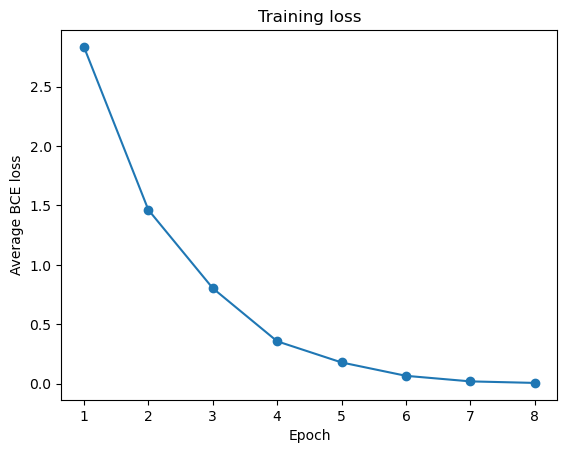

In [51]:

try:
    import matplotlib.pyplot as plt
    plt.figure()
    plt.plot(range(1, len(loss_history)+1), loss_history, marker="o")
    plt.xlabel("Epoch")
    plt.ylabel("Average BCE loss")
    plt.title("Training loss")
    plt.show()
except Exception as e:
    print("matplotlib not available; loss history:", loss_history)


## 9) Evaluation (Jaccard, micro P/R/F1)

In [56]:

def predict_tags(text, threshold=0.5):
    feat = featurize(text)
    p = sigmoid(forward_sparse(feat))
    idxs = np.where(p >= threshold)[0]
    return [labels[i] for i in idxs], p

def jaccard(a, b):
    A, B = set(a), set(b)
    if not A and not B: return 1.0
    return len(A & B) / max(1, len(A | B))

micro_tp = micro_fp = micro_fn = 0
per_label = {lab: {"tp":0,"fp":0,"fn":0} for lab in labels}
jac_list = []

pred_rows = []
for r in valid:
    pred, prob = predict_tags(r["text"], threshold=0.5)
    gold = r["tags"]
    jac_list.append(jaccard(pred, gold))
    pred_rows.append({"talk_id": r["talk_id"], "gold": ", ".join(gold), "pred": ", ".join(pred)})

    P = set(pred); G = set(gold)
    for lab in labels:
        in_p, in_g = (lab in P), (lab in G)
        if in_p and in_g: per_label[lab]["tp"] += 1
        if in_p and not in_g: per_label[lab]["fp"] += 1
        if (not in_p) and in_g: per_label[lab]["fn"] += 1

# micro
for lab in labels:
    micro_tp += per_label[lab]["tp"]
    micro_fp += per_label[lab]["fp"]
    micro_fn += per_label[lab]["fn"]

def safe_div(a,b): return a / b if b else 0.0
micro_prec = safe_div(micro_tp, micro_tp + micro_fp)
micro_rec  = safe_div(micro_tp, micro_tp + micro_fn)
micro_f1   = safe_div(2*micro_prec*micro_rec, micro_prec + micro_rec) if (micro_prec+micro_rec) else 0.0
avg_jac    = sum(jac_list)/max(1,len(jac_list))

print(f"Avg Jaccard: {avg_jac:.3f}")
print(f"Micro Precision: {micro_prec:.3f}  Micro Recall: {micro_rec:.3f}  Micro F1: {micro_f1:.3f}")

# per-label F1
label_scores = []
for lab in labels:
    tp, fp, fn = per_label[lab]["tp"], per_label[lab]["fp"], per_label[lab]["fn"]
    prec = safe_div(tp, tp+fp); rec = safe_div(tp, tp+fn)
    f1 = safe_div(2*prec*rec, prec+rec) if (prec+rec) else 0.0
    label_scores.append((lab, prec, rec, f1))

label_scores.sort(key=lambda x: x[3], reverse=True)
print("Top labels by F1:")
for lab, p, r, f1 in label_scores[:10]:
    print(f"{lab:20s}  P={p:.2f} R={r:.2f} F1={f1:.2f}")

# save predictions
import csv as _csv
with open(PREDICTIONS_CSV, "w", newline="", encoding="utf-8") as f:
    w = _csv.DictWriter(f, fieldnames=["talk_id","gold","pred"])
    w.writeheader()
    for row in pred_rows:
        w.writerow(row)
print("Wrote", PREDICTIONS_CSV, "rows:", len(pred_rows))


/tmp/ipykernel_3887/669017346.py:6: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-x))


Avg Jaccard: 0.312
Micro Precision: 0.534  Micro Recall: 0.359  Micro F1: 0.429
Top labels by F1:
science               P=0.81 R=0.54 F1=0.65
design                P=0.62 R=0.49 F1=0.55
global issues         P=0.66 R=0.46 F1=0.54
health                P=0.59 R=0.50 F1=0.54
history               P=0.70 R=0.38 F1=0.49
social change         P=0.55 R=0.35 F1=0.43
technology            P=0.45 R=0.31 F1=0.37
society               P=0.46 R=0.27 F1=0.34
culture               P=0.35 R=0.32 F1=0.34
technology']          P=0.38 R=0.20 F1=0.26
Wrote local_multilabel_predictions.csv rows: 590


## 10) Per‑label F1 chart

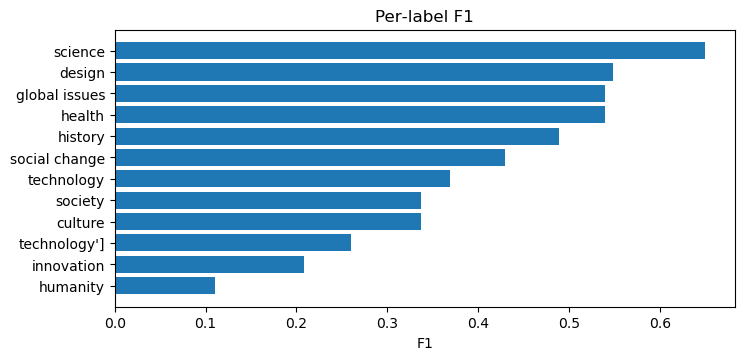

In [53]:

try:
    import matplotlib.pyplot as plt
    labs = [x[0] for x in label_scores]
    f1s  = [x[3] for x in label_scores]
    plt.figure(figsize=(8, max(3, len(labs)*0.3)))
    plt.barh(labs, f1s)
    plt.xlabel("F1")
    plt.title("Per‑label F1")
    plt.gca().invert_yaxis()
    plt.show()
except Exception as e:
    print("matplotlib not available; top‑10:", label_scores[:10])
